# Libraries

In [13]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset
from pprint import pprint

from src.utils import (
    # Old utils
    print_h, eval_person_majority_voting, 

    # New utils
    set_seed, get_device, init_model, init_metrics, update_metrics, save_metrics_to_json,
    plot_k_fold_roc_curves_multiclass_v2, plot_k_fold_cm,
)

# Config

In [14]:
# Project config
seed = 69
set_seed(seed)
device = get_device()
print("Device:", device)

# Model config
model_path = 'checkpoints/InceptionTime_bidirectional_non_moe_Ga_k10_w500_s500_Ju_k10_w500_s500_Si_k10_w500_s250_fold_09_e1_v20250516155139/fold_09.pth'
run_name = model_path.split('/')[-2]
print("Run name:", run_name)
model_name = model_path.split('/')[-2].split('_non_moe')[0]
if 'bidirectional' in model_name:
    bidirectional = True
    model_name = model_name.replace('_bidirectional', '')
else:
    bidirectional = False
print("Model name:", model_name)
print("Bidirectional:", bidirectional)

# Data config
fold_i_dir_map = {
    'Ga': 'data/preprocessed/Ga_k10_w500_s500_v20250430232239/fold_09',
    'Ju': 'data/preprocessed/Ju_k10_w500_s500_v20250430232219/fold_09',
    'Si': 'data/preprocessed/Si_k10_w500_s250_v20250430231926/fold_09',
}
i_folds_data = [int(fold_i_dir.split('fold_')[-1]) for fold_i_dir in fold_i_dir_map.values()]
i_fold_checkpoint = int(model_path.split('fold_')[-1].replace('.pth', ''))
i_folds = i_folds_data + [i_fold_checkpoint]
assert len(set(i_folds)) == 1, f"Fold numbers are inconsistent: {({'data': i_folds_data, 'checkpoint': i_fold_checkpoint})}"
i_fold = i_folds[0]
print("Fold number:", i_fold)

# Evaluation config
# WARNING: Still hard-coded!
n_feat = 16
n_class = 4
window_size = 500
max_vgrf_data_len = 25_000

general_metrics_dir = f'evaluations/{run_name}/_general_metrics'
cm_dir = f'evaluations/{run_name}/cm'
roc_curves_dir = f'evaluations/{run_name}/roc_curves'

print("Evaluation general metrics save directory:", general_metrics_dir)
print("Evaluation confusion matrix save directory:", cm_dir)
print("Evaluation ROC curves save directory:", roc_curves_dir)

Random seed: 69
Device: mps
Run name: InceptionTime_bidirectional_non_moe_Ga_k10_w500_s500_Ju_k10_w500_s500_Si_k10_w500_s250_fold_09_e1_v20250516155139
Model name: InceptionTime
Bidirectional: True
Fold number: 9
Evaluation general metrics save directory: evaluations/InceptionTime_bidirectional_non_moe_Ga_k10_w500_s500_Ju_k10_w500_s500_Si_k10_w500_s250_fold_09_e1_v20250516155139/_general_metrics
Evaluation confusion matrix save directory: evaluations/InceptionTime_bidirectional_non_moe_Ga_k10_w500_s500_Ju_k10_w500_s500_Si_k10_w500_s250_fold_09_e1_v20250516155139/cm
Evaluation ROC curves save directory: evaluations/InceptionTime_bidirectional_non_moe_Ga_k10_w500_s500_Ju_k10_w500_s500_Si_k10_w500_s250_fold_09_e1_v20250516155139/roc_curves


# Evaluation

In [5]:
metrics = init_metrics(['acc', 'f1', 'precision', 'recall', 'cm', 
                        'fpr_multiclass_list', 'tpr_multiclass_list', 'roc_auc_multiclass_list', 'roc_auc_multiclass_avg'])

print_h(f"FOLD {i_fold}", 128)

X_val_person_GaJuSi = torch.empty(0, max_vgrf_data_len, n_feat).float()
y_val_person_GaJuSi = torch.empty(0).long()

X_test_person_GaJuSi = torch.empty(0, max_vgrf_data_len, n_feat).float()
y_test_person_GaJuSi = torch.empty(0).long()

for study, fold_i_dir in fold_i_dir_map.items():
    X_val_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_val_person.npy'))).float()
    y_val_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_val_person.npy'))).long()
    X_val_person_GaJuSi = torch.cat((X_val_person_GaJuSi, X_val_person), dim=0)
    y_val_person_GaJuSi = torch.cat((y_val_person_GaJuSi, y_val_person), dim=0)

    X_test_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_test_person.npy'))).float()
    y_test_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_test_person.npy'))).long()
    X_test_person_GaJuSi = torch.cat((X_test_person_GaJuSi, X_test_person), dim=0)
    y_test_person_GaJuSi = torch.cat((y_test_person_GaJuSi, y_test_person), dim=0)

print_h("NON-MoE MODEL", 96)

val_person_dataset_GaJuSi = TensorDataset(X_val_person_GaJuSi, y_val_person_GaJuSi)
test_person_dataset_GaJuSi = TensorDataset(X_test_person_GaJuSi, y_test_person_GaJuSi)

model = init_model(model_name, device, c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=bidirectional)

print_h("EVALUATION ON PERSON DATA BY MAJORITY VOTING", 64)
(
    _, 
    acc_person_majority_voting, 
    f1_person_majority_voting, 
    precision_person_majority_voting, 
    recall_person_majority_voting, 
    cm_person_majority_voting, 
    _, _, _, 
    fpr_multiclass_list_person_majority_voting, 
    tpr_multiclass_list_person_majority_voting, 
    roc_auc_multiclass_list_person_majority_voting, 
    roc_auc_multiclass_avg_person_majority_voting
) = eval_person_majority_voting(
    model, 
    val_person_dataset_GaJuSi, 
    criterion=None, 
    average='weighted',
    window_size=window_size, 
    debug=False
)
print("acc:", acc_person_majority_voting)
print("f1:", f1_person_majority_voting)
print("precision:", precision_person_majority_voting)
print("recall:", recall_person_majority_voting)
print("cm:\n", np.array(cm_person_majority_voting))
print()

metrics = update_metrics(metrics, {
    'acc': acc_person_majority_voting,
    'f1': f1_person_majority_voting,
    'precision': precision_person_majority_voting,
    'recall': recall_person_majority_voting,
    'cm': cm_person_majority_voting,
    'fpr_multiclass_list': fpr_multiclass_list_person_majority_voting, 
    'tpr_multiclass_list': tpr_multiclass_list_person_majority_voting, 
    'roc_auc_multiclass_list': roc_auc_multiclass_list_person_majority_voting,
    'roc_auc_multiclass_avg': roc_auc_multiclass_avg_person_majority_voting,
})

                                                             FOLD 9                                                             
                                         NON-MoE MODEL                                          
          EVALUATION ON PERSON DATA BY MAJORITY VOTING          
acc: 0.3333333333333333
f1: 0.16666666666666666
precision: 0.1111111111111111
recall: 0.3333333333333333
cm:
 [[ 0 12  0  0]
 [ 0 13  0  0]
 [ 0 11  0  0]
 [ 0  3  0  0]]



In [15]:
print_h("NON-MoE MODEL METRICS", 128)
save_metrics_to_json(metrics, general_metrics_dir, f'_non_moe.json')
pprint(metrics, sort_dicts=False)

                                                     NON-MoE MODEL METRICS                                                      
{'acc': {'folds': [0.3333333333333333], 'avg': 0.3333333333333333, 'std': 0.0},
 'f1': {'folds': [0.16666666666666666], 'avg': 0.16666666666666666, 'std': 0.0},
 'precision': {'folds': [0.1111111111111111],
               'avg': 0.1111111111111111,
               'std': 0.0},
 'recall': {'folds': [0.3333333333333333],
            'avg': 0.3333333333333333,
            'std': 0.0},
 'cm': {'folds': [[[0, 12, 0, 0], [0, 13, 0, 0], [0, 11, 0, 0], [0, 3, 0, 0]]]},
 'fpr_multiclass_list': {'folds': [[[0.0,
                                     0.037037037037037035,
                                     0.37037037037037035,
                                     0.37037037037037035,
                                     0.4074074074074074,
                                     0.4074074074074074,
                                     0.4444444444444444,
                  

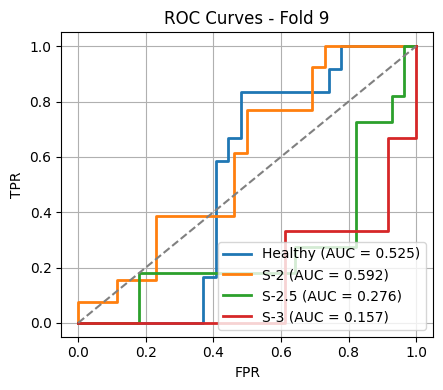

Saved in: evaluations/InceptionTime_bidirectional_non_moe_Ga_k10_w500_s500_Ju_k10_w500_s500_Si_k10_w500_s250_fold_09_e1_v20250516155139/roc_curves


In [16]:
plot_k_fold_roc_curves_multiclass_v2(
    fpr_folds=metrics['fpr_multiclass_list']['folds'],
    tpr_folds=metrics['tpr_multiclass_list']['folds'],
    auc_folds=metrics['roc_auc_multiclass_list']['folds'],
    class_names=["Healthy", "S-2", "S-2.5", "S-3"],
    save_dir=roc_curves_dir,
    i_folds=[i_fold],
)

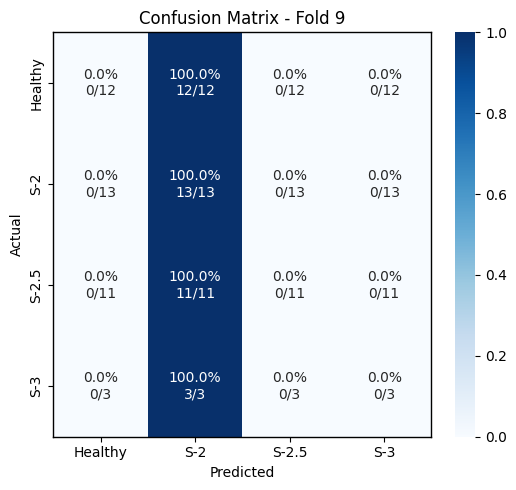

Saved in: evaluations/InceptionTime_bidirectional_non_moe_Ga_k10_w500_s500_Ju_k10_w500_s500_Si_k10_w500_s250_fold_09_e1_v20250516155139/cm


In [17]:
plot_k_fold_cm(
    metrics['cm']['folds'], 
    class_names=["Healthy", "S-2", "S-2.5", "S-3"],
    save_dir=cm_dir,
    figsize=(25, 5),
    i_folds=[i_fold],
)